<a href="https://colab.research.google.com/github/souhirbenamor/EPF/blob/main/Multi_RNN%2C_LSTM_simple_and_deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.7.12


In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [14]:
import pandas as pd
df = pd.read_csv('/content/BE.csv')
#df.drop(df.loc[df['Date'].duplicated()].index, inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

#df = df.sort_values(df['Date'], ascending=[True])


df.set_index(df['Date'], inplace = True)
df.drop(columns = [ 'Date'], inplace = True)

In [15]:
df


,Prices,Generation forecast,System load forecast
Date,,,
2011-01-09 00:00:00,32.54,63065.0,63000.0
2011-01-09 01:00:00,21.55,62715.0,58800.0
2011-01-09 02:00:00,15.71,61952.0,58500.0
2011-01-09 03:00:00,10.58,59262.0,54300.0
2011-01-09 04:00:00,10.32,56883.0,51900.0
...,...,...,...
2016-12-31 19:00:00,40.84,70329.0,73957.0
2016-12-31 20:00:00,40.10,69121.0,72544.0
2016-12-31 21:00:00,36.00,66647.0,69451.0


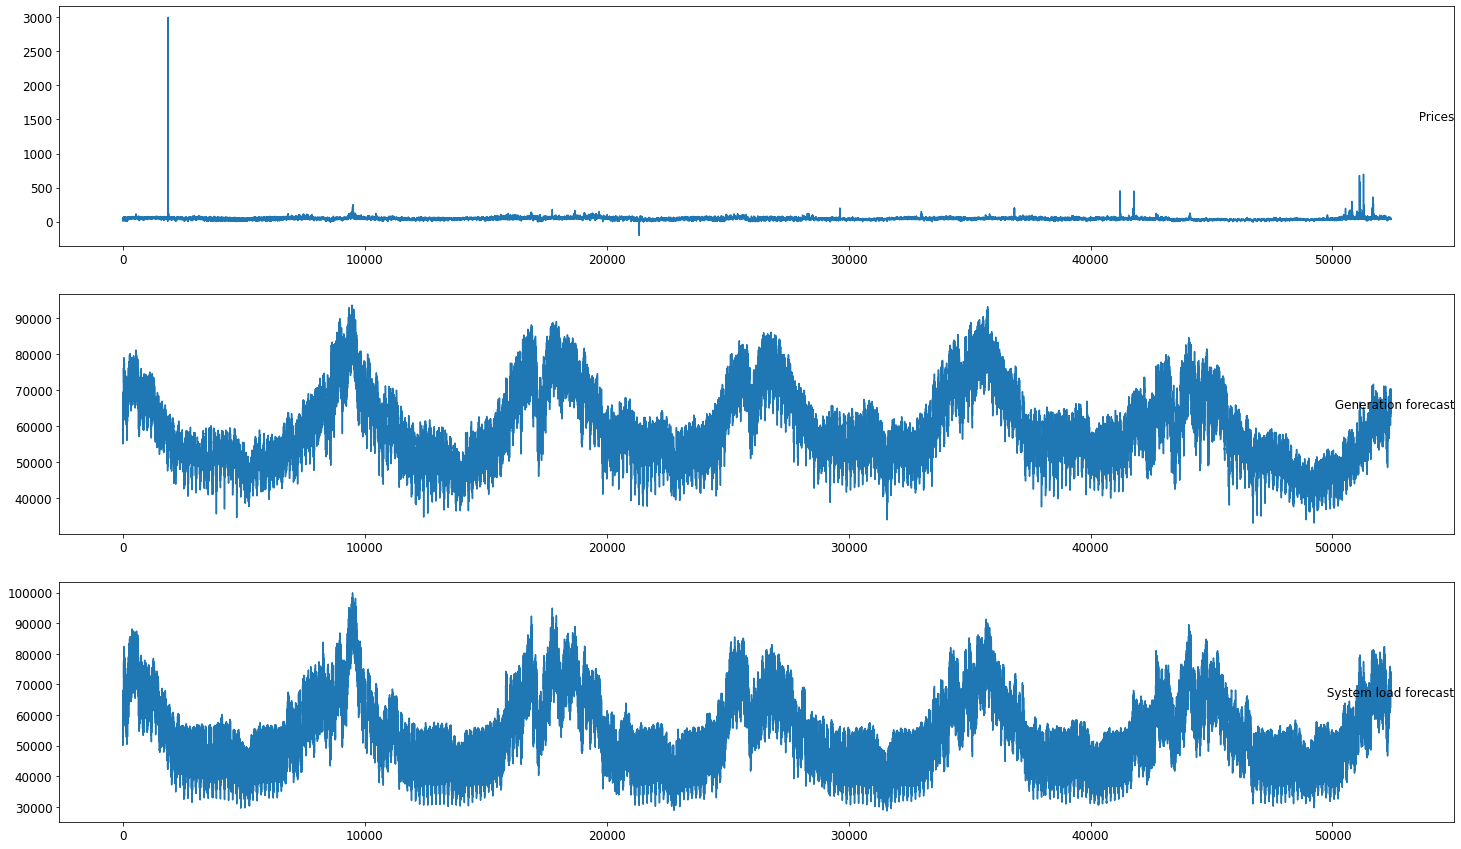

In [16]:
values = df.values

groups = [0, 1, 2]
i = 1

# plot each column
plt.figure(figsize = (25, 15))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [17]:
import seaborn as sns

In [18]:
df.shape

(52416, 3)

In [19]:
n_steps = 168

In [20]:
n_steps = 168
data = df.values

In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()

scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df)

data = scaled_df.values

In [22]:
series_reshaped =  np.array([data[i:i + (n_steps+24)].copy() for i in range(len(data) - (n_steps+24))])

In [23]:
series_reshaped.shape

(52224, 192, 3)

In [24]:
X_train = series_reshaped[:25000, :n_steps]
X_valid = series_reshaped[25000:34944, :n_steps]
X_test = series_reshaped[34944:, :n_steps]
Y = np.empty((52224, n_steps, 24))

for step_ahead in range(1, 24 + 1):
    Y[..., step_ahead - 1] = series_reshaped[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:25000]
Y_valid = Y[25000:34944]
Y_test = Y[34944:]

In [25]:
from keras import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

In [26]:
es = EarlyStopping(monitor = 'val_loss')

# Deep Multivariate Recurrant Neural Network

In [27]:
np.random.seed(42)
tf.random.set_seed(42)

model6 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 3]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

model6.compile(loss="mape", optimizer="adam")
history = model6.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
782/782 [==============================] - 244s 307ms/step - loss: 2302.7043 - val_loss: 92.9214
Epoch 2/20
782/782 [==============================] - 207s 265ms/step - loss: 652.0278 - val_loss: 86.8567
Epoch 3/20
782/782 [==============================] - 187s 240ms/step - loss: 507.8321 - val_loss: 84.5154
Epoch 4/20
782/782 [==============================] - 192s 245ms/step - loss: 355.8717 - val_loss: 82.8365
Epoch 5/20
782/782 [==============================] - 189s 242ms/step - loss: 354.2658 - val_loss: 81.6557
Epoch 6/20
782/782 [==============================] - 186s 238ms/step - loss: 326.9423 - val_loss: 79.8891
Epoch 7/20
782/782 [==============================] - 186s 238ms/step - loss: 293.7917 - val_loss: 80.2253
Epoch 8/20
782/782 [==============================] - 188s 240ms/step - loss: 300.0037 - val_loss: 81.1152
Epoch 9/20
782/782 [==============================] - 187s 239ms/step - loss: 284.8483 - val_loss: 82.3715
Epoch 10/20
782/782 [===============

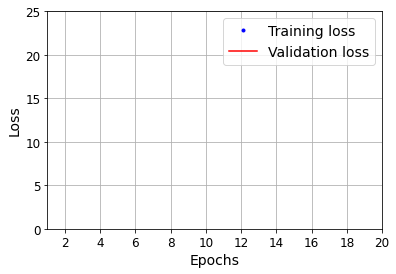

In [28]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 25])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [29]:
Y_pred = model6.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][0][23]))
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

#Save Results
import pandas as pd
import csv

actual=pd.DataFrame(actual)
actual.to_csv("RNNresults.csv", quoting=csv.QUOTE_NONE, escapechar=' ')
# from google.colab import files
# actual.to_csv('RNNresults.csv') 
# files.download('RNNresults.csv')

In [30]:
np.mean(actual['difference_percentage'])

77.81550543066272

In [40]:
print(actual)

         actual         1  ...  difference  difference_percentage
0      0.073854  0.593798  ...    0.039575              53.585533
1      0.072610  0.550742  ...    0.042952              59.153638
2      0.071157  0.539510  ...    0.042271              59.404891
3      0.070969  0.486813  ...    0.047211              66.523899
4      0.070972  0.464946  ...    0.049726              70.064086
...         ...       ...  ...         ...                    ...
17275  0.077108  0.568021  ...    0.043997              57.058103
17276  0.076227  0.521238  ...    0.047361              62.132156
17277  0.074886  0.493208  ...    0.048940              65.352680
17278  0.074314  0.477603  ...    0.050156              67.492617
17279  0.073267  0.485637  ...    0.047334              64.604776

[17280 rows x 6 columns]


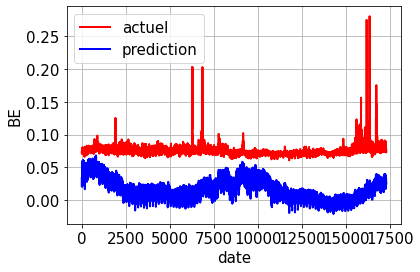

In [55]:
#Plot prediction results
# Plot
original=actual['actual']
Pred=actual['predictions']
plt.plot(original,'r',lw =2)
plt.plot(Pred, color='b',lw=2)
#plt.xlim([0,525])
plt.xlabel('date', fontsize =15)
plt.ylabel('BE',fontsize =15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['actuel','prediction'],prop={'size': 15})
plt.grid()
plt.savefig('RNN_Pred', figsize=(15,10), transparent=True, dpi=300)

# Simple Long-Short Term Memory Model

In [56]:
np.random.seed(42)
tf.random.set_seed(42)

model8 = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 3]),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

model8.compile(loss="mape", optimizer="adam")
history = model8.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
782/782 [==============================] - 11s 10ms/step - loss: 556.8667 - val_loss: 89.9118
Epoch 2/20
782/782 [==============================] - 7s 9ms/step - loss: 348.1482 - val_loss: 88.5641
Epoch 3/20
782/782 [==============================] - 7s 9ms/step - loss: 355.1288 - val_loss: 87.4325
Epoch 4/20
782/782 [==============================] - 7s 9ms/step - loss: 280.8726 - val_loss: 87.8712
Epoch 5/20
782/782 [==============================] - 7s 9ms/step - loss: 272.1190 - val_loss: 87.9614
Epoch 6/20
782/782 [==============================] - 7s 9ms/step - loss: 274.1888 - val_loss: 86.1819
Epoch 7/20
782/782 [==============================] - 7s 9ms/step - loss: 238.1336 - val_loss: 80.4114
Epoch 8/20
782/782 [==============================] - 8s 11ms/step - loss: 266.4550 - val_loss: 77.4766
Epoch 9/20
782/782 [==============================] - 7s 9ms/step - loss: 237.5493 - val_loss: 77.8431
Epoch 10/20
782/782 [==============================] - 7s 9ms/step - l

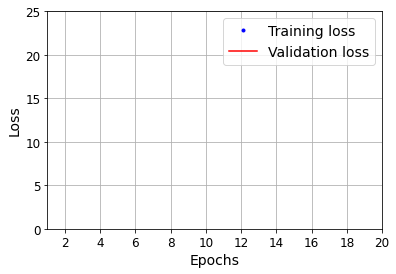

In [57]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [58]:
Y_pred = model8.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][0][23]))
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

#Save Results
import pandas as pd
import csv

actual=pd.DataFrame(actual)
actual.to_csv("simplelstmresults.csv", quoting=csv.QUOTE_NONE, escapechar=' ')
# from google.colab import files
# actual.to_csv('simplelstmresults.csv') 
# files.download('simplelstmresults.csv')

In [59]:
np.mean(actual['difference_percentage'])

80.0860980922678

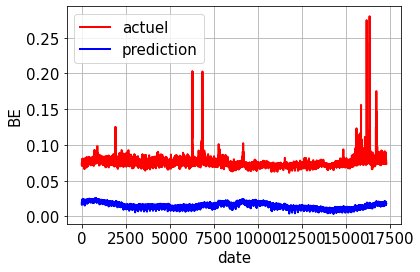

In [60]:
#Plot prediction results
# Plot
original=actual['actual']
Pred=actual['predictions']
plt.plot(original,'r',lw =2)
plt.plot(Pred, color='b',lw=2)
#plt.xlim([0,525])
plt.xlabel('date', fontsize =15)
plt.ylabel('BE',fontsize =15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['actuel','prediction'],prop={'size': 15})
plt.grid()
plt.savefig('S_LSTM_Pred', figsize=(15,10), transparent=True, dpi=300)

# Deep LSTM model

In [61]:
np.random.seed(42)
tf.random.set_seed(42)

model9 = keras.models.Sequential([
    keras.layers.LSTM(80, return_sequences= True, input_shape=(168,3)),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(40, return_sequences= True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(30, return_sequences= True),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

model9.compile(loss="mape", optimizer="adam")
history9 = model9.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid), callbacks = [es] )

Epoch 1/20
782/782 [==============================] - 22s 23ms/step - loss: 550.3270 - val_loss: 98.2704
Epoch 2/20
782/782 [==============================] - 17s 21ms/step - loss: 306.5878 - val_loss: 98.1928


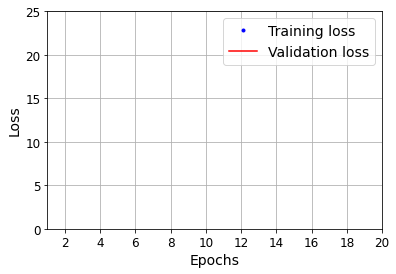

In [62]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [63]:
Y_pred = model9.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][0][23]))
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

#Save Results
import pandas as pd
import csv

actual=pd.DataFrame(actual)
actual.to_csv("deeplstmresults.csv", quoting=csv.QUOTE_NONE, escapechar=' ')
 #from google.colab import files
# actual.to_csv('deeplstmresults.csv') 
 
#files.download('deeplstmresults.csv')

In [64]:
np.mean(actual['difference_percentage'])

98.35146434964904

In [65]:
np.random.seed(42)
tf.random.set_seed(42)

model10 = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 3]),
    keras.layers.GRU(60, return_sequences=True),
    keras.layers.GRU(40, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

model10.compile(loss="mape", optimizer="adam")
history2 = model10.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]), callbacks = [es])

Epoch 1/20
782/782 [==============================] - 17s 11ms/step - loss: 913.0104 - val_loss: 95.7986
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 494.0850 - val_loss: 94.1320


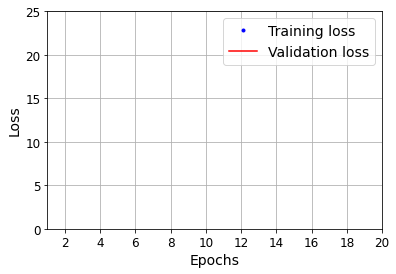

In [66]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [67]:
Y_pred = model10.predict(X_test)

In [68]:
Y_pred.shape

(17280, 83, 24)

In [69]:
Y_pred = model10.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][3::2][0][23]))
    

actual = pd.DataFrame(X_test[: , 0, 0])
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100
np.mean(actual['difference_percentage'])

#Save Results
import pandas as pd
import csv

actual=pd.DataFrame(actual)
actual.to_csv("convlayerresults.csv", quoting=csv.QUOTE_NONE, escapechar=' ')
# from google.colab import files
# actual.to_csv('convlayerresults.csv') 
# files.download('convlayerresults.csv')

In [70]:
np.mean(actual['difference_percentage'])

99.73587941688673

In [71]:
print(actual)

         actual  predictions  difference  difference_percentage
0      0.073854     0.001466    0.072388              98.014480
1      0.072610     0.001692    0.070918              97.669539
2      0.071157     0.002120    0.069036              97.020411
3      0.070969     0.002510    0.068459              96.463210
4      0.070972     0.002641    0.068332              96.279374
...         ...          ...         ...                    ...
17275  0.077108    -0.000016    0.077124             100.020244
17276  0.076227    -0.000270    0.076497             100.354425
17277  0.074886    -0.000360    0.075246             100.481358
17278  0.074314    -0.000345    0.074658             100.463601
17279  0.073267    -0.000068    0.073334             100.092408

[17280 rows x 4 columns]


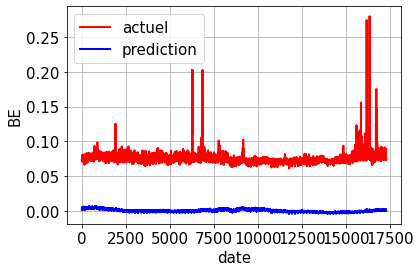

In [72]:
#Plot prediction results
# Plot
original=actual['actual']
Pred=actual['predictions']
plt.plot(original,'r',lw =2)
plt.plot(Pred, color='b',lw=2)
#plt.xlim([0,525])
plt.xlabel('date', fontsize =15)
plt.ylabel('BE',fontsize =15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['actuel','prediction'],prop={'size': 15})
plt.grid()
plt.savefig('Deep_LSTM_Pred', figsize=(15,10), transparent=True, dpi=300)